In [5]:
from src.helpers.experiment import create_tsfresh_dataframe
from src.helpers.diabetes.cega import clarke_error_grid
from src.helpers.diabetes.madex import mean_adjusted_exponent_error
from pycaret.regression import setup, create_model, compare_models, predict_model, get_config, pull
import matplotlib.pyplot as plt
from loguru import logger
import warnings
import numpy as np
from sklearn.metrics import mean_squared_error
import pandas

In [6]:
def run(patient, window, horizon):
    print(patient,window,horizon)
    

    train_parameters = {
        'ohio_no': patient,
        'scope': 'train',
        'train_ds_size': 0,
        'window_size': window,
        'prediction_horizon': horizon,
        'minimal_features': False,
    }

    unseen_data_parameters = {
        'ohio_no': patient,
        'scope': 'test',
        'train_ds_size': 0,
        'window_size': window,
        'prediction_horizon': horizon,
        'minimal_features': False,
    }
    
    source_df = create_tsfresh_dataframe(train_parameters)
    clean_df = source_df.drop(
        columns=['start', 'end', 'start_time', 'end_time'])
    print(clean_df.columns)
    
    regressor = setup(clean_df,
        target='label',
        feature_selection=True,
        ignore_low_variance=True,  
        html=False,
        silent=True,
        verbose=False,
        session_id=1974
        )
    print(get_config('prep_pipe'))
    print(get_config('X').columns)
    
    best3 = compare_models(
        exclude=['catboost', 'xgboost', 'et', 'rf', 'ada', 'gbr'],
        sort='RMSE',
        n_select=3,
        verbose=True
    )
    comparison_df = pull()
    display(comparison_df)
    
    
    output = {}
    output['patient'] = patient
    output['window']  = f'{window}({(window*5)} minutes)'
    output['horizon']  = f'{horizon}({(horizon*5)} minutes)'
    model = create_model(best3[0])
    first_model_df = pull()
    display(first_model_df)
    model_name = model.__str__().split('(')[0]
    logger.info(f'Processing model: {model_name}')
    output['model'] = model
    output['model_name'] = model_name
    pd = predict_model(model)
    legend = f'[{patient}]Holdout_W{(window*5)}_H{(horizon*5)}'
    (fig, res) = clarke_error_grid(pd['label'], pd['Label'], legend)
    plt.show()
    fig.savefig(f'figures/{legend}.png')
    output['internal_cga_analysis'] = res
    rmse = np.sqrt(mean_squared_error(pd['label'], pd['Label']))
    rmadex = np.sqrt(mean_adjusted_exponent_error(
        pd['label'], pd['Label']))
    output['internal_rmse'] = rmse
    output['internal_rmadex'] = rmadex

    unseen_df = create_tsfresh_dataframe(unseen_data_parameters)
    clean_unseen_df = unseen_df.drop(
        columns=['start', 'end', 'start_time', 'end_time'])
    unseen_pd = predict_model(model, data=clean_unseen_df)
    legend = f'[{patient}]Unseen_W{(window*5)}_H{(horizon*5)}'
    (fig, res) = clarke_error_grid(unseen_pd['label'], unseen_pd['Label'], legend)
    plt.show()
    fig.savefig(f'figures/{legend}.png')
    output['unseen_cga_analysis'] = res
    rmse = np.sqrt(mean_squared_error(unseen_pd['label'], unseen_pd['Label']))
    rmadex = np.sqrt(mean_adjusted_exponent_error(
        unseen_pd['label'], unseen_pd['Label']))
    output['unseen_rmse'] = rmse
    output['unseen_rmadex'] = rmadex
#     logger.info(output)
    
    return output
    
    
    

2021-07-13 08:07:14.554 | INFO     | src.helpers.experiment:create_ds_name:12 - dataframes/559_train_0_12_6.pkl
2021-07-13 08:07:14.632 | INFO     | src.helpers.experiment:create_tsfresh_dataframe:19 - {'ohio_no': 559, 'scope': 'train', 'train_ds_size': 0, 'window_size': 12, 'prediction_horizon': 6, 'minimal_features': False}
559 12 6


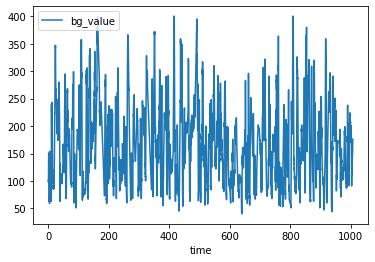

2021-07-13 08:07:15.136 | INFO     | src.helpers.experiment:create_tsfresh_dataframe:22 - Found existing picle file. Continuing...
2021-07-13 08:07:15.138 | INFO     | src.helpers.dataframe:read_df:11 - Attempting to read from pickle file dataframes/559_train_0_12_6.pkl
Index(['bg_value__variance_larger_than_standard_deviation',
       'bg_value__has_duplicate_max', 'bg_value__has_duplicate_min',
       'bg_value__has_duplicate', 'bg_value__sum_values',
       'bg_value__abs_energy', 'bg_value__mean_abs_change',
       'bg_value__mean_change', 'bg_value__mean_second_derivative_central',
       'bg_value__median',
       ...
       'bg_value__permutation_entropy__dimension_6__tau_1',
       'bg_value__permutation_entropy__dimension_7__tau_1',
       'bg_value__query_similarity_count__query_None__threshold_0.0',
       'bg_value__matrix_profile__feature_"min"__threshold_0.98',
       'bg_value__matrix_profile__feature_"max"__threshold_0.98',
       'bg_value__matrix_profile__feature_"mea

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lr,Linear Regression,31.9793,1716.9336,41.3751,0.6506,0.2776,0.2369,0.463


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lasso,Lasso Regression,19.3243,845.3038,29.0193,0.8281,0.1852,0.1291,0.394
lr,Linear Regression,31.9793,1716.9336,41.3751,0.6506,0.2776,0.2369,0.463


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lasso,Lasso Regression,19.3243,845.3038,29.0193,0.8281,0.1852,0.1291,0.394
lr,Linear Regression,31.9793,1716.9336,41.3751,0.6506,0.2776,0.2369,0.463
ridge,Ridge Regression,34.1804,4235.0101,57.7837,0.1468,0.2911,0.2536,0.112


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
en,Elastic Net,19.2894,845.0408,29.0130,0.8281,0.1849,0.1288,0.345
lasso,Lasso Regression,19.3243,845.3038,29.0193,0.8281,0.1852,0.1291,0.394
lr,Linear Regression,31.9793,1716.9336,41.3751,0.6506,0.2776,0.2369,0.463
ridge,Ridge Regression,34.1804,4235.0101,57.7837,0.1468,0.2911,0.2536,0.112


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
en,Elastic Net,19.2894,845.0408,29.0130,0.8281,0.1849,0.1288,0.345
lasso,Lasso Regression,19.3243,845.3038,29.0193,0.8281,0.1852,0.1291,0.394
lr,Linear Regression,31.9793,1716.9336,41.3751,0.6506,0.2776,0.2369,0.463
ridge,Ridge Regression,34.1804,4235.0101,57.7837,0.1468,0.2911,0.2536,0.112
llar,Lasso Least Angle Regression,57.7303,4934.6499,70.2344,-0.0028,0.4417,0.4308,0.305


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
omp,Orthogonal Matching Pursuit,19.5308,817.8981,28.5793,0.8337,0.1806,0.1305,0.035
en,Elastic Net,19.2894,845.0408,29.0130,0.8281,0.1849,0.1288,0.345
lasso,Lasso Regression,19.3243,845.3038,29.0193,0.8281,0.1852,0.1291,0.394
lr,Linear Regression,31.9793,1716.9336,41.3751,0.6506,0.2776,0.2369,0.463
ridge,Ridge Regression,34.1804,4235.0101,57.7837,0.1468,0.2911,0.2536,0.112
llar,Lasso Least Angle Regression,57.7303,4934.6499,70.2344,-0.0028,0.4417,0.4308,0.305


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
omp,Orthogonal Matching Pursuit,19.5308,817.8981,28.5793,0.8337,0.1806,0.1305,0.035
br,Bayesian Ridge,19.3037,841.7583,28.9585,0.8288,0.1841,0.1290,0.167
en,Elastic Net,19.2894,845.0408,29.0130,0.8281,0.1849,0.1288,0.345
lasso,Lasso Regression,19.3243,845.3038,29.0193,0.8281,0.1852,0.1291,0.394
lr,Linear Regression,31.9793,1716.9336,41.3751,0.6506,0.2776,0.2369,0.463
ridge,Ridge Regression,34.1804,4235.0101,57.7837,0.1468,0.2911,0.2536,0.112
llar,Lasso Least Angle Regression,57.7303,4934.6499,70.2344,-0.0028,0.4417,0.4308,0.305


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
omp,Orthogonal Matching Pursuit,19.5308,8.178981e+02,28.5793,0.8337,0.1806,0.1305,0.035
br,Bayesian Ridge,19.3037,8.417583e+02,28.9585,0.8288,0.1841,0.1290,0.167
en,Elastic Net,19.2894,8.450408e+02,29.0130,0.8281,0.1849,0.1288,0.345
lasso,Lasso Regression,19.3243,8.453038e+02,29.0193,0.8281,0.1852,0.1291,0.394
lr,Linear Regression,31.9793,1.716934e+03,41.3751,0.6506,0.2776,0.2369,0.463
ridge,Ridge Regression,34.1804,4.235010e+03,57.7837,0.1468,0.2911,0.2536,0.112
llar,Lasso Least Angle Regression,57.7303,4.934650e+03,70.2344,-0.0028,0.4417,0.4308,0.305
par,Passive Aggressive Regressor,1185.0791,1.168164e+09,19626.1590,-249856.7907,0.9225,14.4118,0.069


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
omp,Orthogonal Matching Pursuit,19.5308,8.178981e+02,28.5793,0.8337,0.1806,0.1305,0.035
br,Bayesian Ridge,19.3037,8.417583e+02,28.9585,0.8288,0.1841,0.1290,0.167
en,Elastic Net,19.2894,8.450408e+02,29.0130,0.8281,0.1849,0.1288,0.345
lasso,Lasso Regression,19.3243,8.453038e+02,29.0193,0.8281,0.1852,0.1291,0.394
lr,Linear Regression,31.9793,1.716934e+03,41.3751,0.6506,0.2776,0.2369,0.463
ridge,Ridge Regression,34.1804,4.235010e+03,57.7837,0.1468,0.2911,0.2536,0.112
llar,Lasso Least Angle Regression,57.7303,4.934650e+03,70.2344,-0.0028,0.4417,0.4308,0.305
huber,Huber Regressor,152.0798,2.874979e+04,167.3220,-4.8873,4.2983,0.9192,0.247
par,Passive Aggressive Regressor,1185.0791,1.168164e+09,19626.1590,-249856.7907,0.9225,14.4118,0.069


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
omp,Orthogonal Matching Pursuit,19.5308,8.178981e+02,28.5793,0.8337,0.1806,0.1305,0.035
br,Bayesian Ridge,19.3037,8.417583e+02,28.9585,0.8288,0.1841,0.1290,0.167
en,Elastic Net,19.2894,8.450408e+02,29.0130,0.8281,0.1849,0.1288,0.345
lasso,Lasso Regression,19.3243,8.453038e+02,29.0193,0.8281,0.1852,0.1291,0.394
knn,K Neighbors Regressor,24.9037,1.221494e+03,34.9338,0.7514,0.2219,0.1673,0.345
lr,Linear Regression,31.9793,1.716934e+03,41.3751,0.6506,0.2776,0.2369,0.463
ridge,Ridge Regression,34.1804,4.235010e+03,57.7837,0.1468,0.2911,0.2536,0.112
llar,Lasso Least Angle Regression,57.7303,4.934650e+03,70.2344,-0.0028,0.4417,0.4308,0.305
huber,Huber Regressor,152.0798,2.874979e+04,167.3220,-4.8873,4.2983,0.9192,0.247
par,Passive Aggressive Regressor,1185.0791,1.168164e+09,19626.1590,-249856.7907,0.9225,14.4118,0.069


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
omp,Orthogonal Matching Pursuit,19.5308,8.178981e+02,28.5793,0.8337,0.1806,0.1305,0.035
br,Bayesian Ridge,19.3037,8.417583e+02,28.9585,0.8288,0.1841,0.1290,0.167
en,Elastic Net,19.2894,8.450408e+02,29.0130,0.8281,0.1849,0.1288,0.345
lasso,Lasso Regression,19.3243,8.453038e+02,29.0193,0.8281,0.1852,0.1291,0.394
knn,K Neighbors Regressor,24.9037,1.221494e+03,34.9338,0.7514,0.2219,0.1673,0.345
dt,Decision Tree Regressor,24.2655,1.366946e+03,36.9377,0.7223,0.2329,0.1625,0.934
lr,Linear Regression,31.9793,1.716934e+03,41.3751,0.6506,0.2776,0.2369,0.463
ridge,Ridge Regression,34.1804,4.235010e+03,57.7837,0.1468,0.2911,0.2536,0.112
llar,Lasso Least Angle Regression,57.7303,4.934650e+03,70.2344,-0.0028,0.4417,0.4308,0.305
huber,Huber Regressor,152.0798,2.874979e+04,167.3220,-4.8873,4.2983,0.9192,0.247


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,17.1811,6.193022e+02,24.8703,0.8740,0.1592,0.1152,1.773
omp,Orthogonal Matching Pursuit,19.5308,8.178981e+02,28.5793,0.8337,0.1806,0.1305,0.035
br,Bayesian Ridge,19.3037,8.417583e+02,28.9585,0.8288,0.1841,0.1290,0.167
en,Elastic Net,19.2894,8.450408e+02,29.0130,0.8281,0.1849,0.1288,0.345
lasso,Lasso Regression,19.3243,8.453038e+02,29.0193,0.8281,0.1852,0.1291,0.394
knn,K Neighbors Regressor,24.9037,1.221494e+03,34.9338,0.7514,0.2219,0.1673,0.345
dt,Decision Tree Regressor,24.2655,1.366946e+03,36.9377,0.7223,0.2329,0.1625,0.934
lr,Linear Regression,31.9793,1.716934e+03,41.3751,0.6506,0.2776,0.2369,0.463
ridge,Ridge Regression,34.1804,4.235010e+03,57.7837,0.1468,0.2911,0.2536,0.112
llar,Lasso Least Angle Regression,57.7303,4.934650e+03,70.2344,-0.0028,0.4417,0.4308,0.305


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,17.1811,6.193022e+02,24.8703,0.8740,0.1592,0.1152,1.773
omp,Orthogonal Matching Pursuit,19.5308,8.178981e+02,28.5793,0.8337,0.1806,0.1305,0.035
br,Bayesian Ridge,19.3037,8.417583e+02,28.9585,0.8288,0.1841,0.1290,0.167
en,Elastic Net,19.2894,8.450408e+02,29.0130,0.8281,0.1849,0.1288,0.345
lasso,Lasso Regression,19.3243,8.453038e+02,29.0193,0.8281,0.1852,0.1291,0.394
knn,K Neighbors Regressor,24.9037,1.221494e+03,34.9338,0.7514,0.2219,0.1673,0.345
dt,Decision Tree Regressor,24.2655,1.366946e+03,36.9377,0.7223,0.2329,0.1625,0.934
lr,Linear Regression,31.9793,1.716934e+03,41.3751,0.6506,0.2776,0.2369,0.463
ridge,Ridge Regression,34.1804,4.235010e+03,57.7837,0.1468,0.2911,0.2536,0.112
llar,Lasso Least Angle Regression,57.7303,4.934650e+03,70.2344,-0.0028,0.4417,0.4308,0.305


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,17.1811,6.193022e+02,24.8703,0.8740,0.1592,0.1152,1.773
omp,Orthogonal Matching Pursuit,19.5308,8.178981e+02,28.5793,0.8337,0.1806,0.1305,0.035
br,Bayesian Ridge,19.3037,8.417583e+02,28.9585,0.8288,0.1841,0.1290,0.167
en,Elastic Net,19.2894,8.450408e+02,29.0130,0.8281,0.1849,0.1288,0.345
lasso,Lasso Regression,19.3243,8.453038e+02,29.0193,0.8281,0.1852,0.1291,0.394
knn,K Neighbors Regressor,24.9037,1.221494e+03,34.9338,0.7514,0.2219,0.1673,0.345
dt,Decision Tree Regressor,24.2655,1.366946e+03,36.9377,0.7223,0.2329,0.1625,0.934
lr,Linear Regression,31.9793,1.716934e+03,41.3751,0.6506,0.2776,0.2369,0.463
ridge,Ridge Regression,34.1804,4.235010e+03,57.7837,0.1468,0.2911,0.2536,0.112
llar,Lasso Least Angle Regression,57.7303,4.934650e+03,70.2344,-0.0028,0.4417,0.4308,0.305


,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,17.2616,604.9100,24.5949,0.8727,0.1640,0.1202
1,17.4695,590.3367,24.2968,0.8883,0.1543,0.1149
2,17.7901,680.2388,26.0814,0.8616,0.1687,0.1209
3,16.5847,562.7958,23.7233,0.8865,0.1494,0.1085
4,17.6877,697.7858,26.4156,0.8621,0.1613,0.1157
5,16.8526,587.4531,24.2374,0.8835,0.1588,0.1136
6,17.1763,636.0653,25.2203,0.8671,0.1624,0.1151
7,17.1145,657.4700,25.6412,0.8627,0.1598,0.1123
8,17.0012,604.5815,24.5882,0.8799,0.1617,0.1176
9,16.8729,571.3847,23.9037,0.8754,0.1520,0.1128


,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,17.2616,604.9100,24.5949,0.8727,0.1640,0.1202
1,17.4695,590.3367,24.2968,0.8883,0.1543,0.1149
2,17.7901,680.2388,26.0814,0.8616,0.1687,0.1209
3,16.5847,562.7958,23.7233,0.8865,0.1494,0.1085
4,17.6877,697.7858,26.4156,0.8621,0.1613,0.1157
5,16.8526,587.4531,24.2374,0.8835,0.1588,0.1136
6,17.1763,636.0653,25.2203,0.8671,0.1624,0.1151
7,17.1145,657.4700,25.6412,0.8627,0.1598,0.1123
8,17.0012,604.5815,24.5882,0.8799,0.1617,0.1176
9,16.8729,571.3847,23.9037,0.8754,0.1520,0.1128


2021-07-13 08:09:02.618 | INFO     | __main__:run:58 - Processing model: LGBMRegressor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,16.7987,611.3725,24.7259,0.8803,0.1641,0.1177


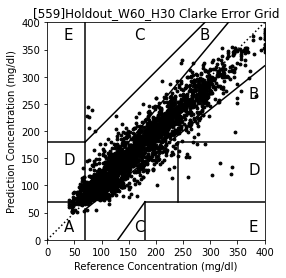

2021-07-13 08:09:03.646 | INFO     | src.helpers.experiment:create_ds_name:12 - dataframes/559_test_0_12_6.pkl
2021-07-13 08:09:03.673 | INFO     | src.helpers.experiment:create_tsfresh_dataframe:19 - {'ohio_no': 559, 'scope': 'test', 'train_ds_size': 0, 'window_size': 12, 'prediction_horizon': 6, 'minimal_features': False}


<Figure size 432x288 with 0 Axes>

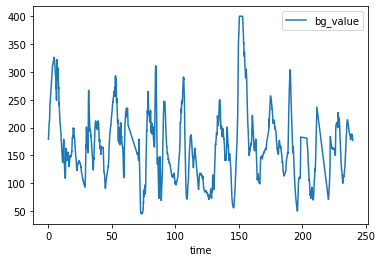

2021-07-13 08:09:03.974 | INFO     | src.helpers.experiment:create_tsfresh_dataframe:22 - Found existing picle file. Continuing...
2021-07-13 08:09:03.976 | INFO     | src.helpers.dataframe:read_df:11 - Attempting to read from pickle file dataframes/559_test_0_12_6.pkl


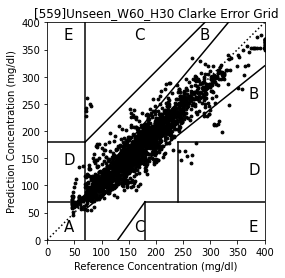

2021-07-13 08:09:05.929 | INFO     | src.helpers.experiment:create_ds_name:12 - dataframes/559_train_0_6_6.pkl
2021-07-13 08:09:06.017 | INFO     | src.helpers.experiment:create_tsfresh_dataframe:19 - {'ohio_no': 559, 'scope': 'train', 'train_ds_size': 0, 'window_size': 6, 'prediction_horizon': 6, 'minimal_features': False}
559 6 6


<Figure size 432x288 with 0 Axes>

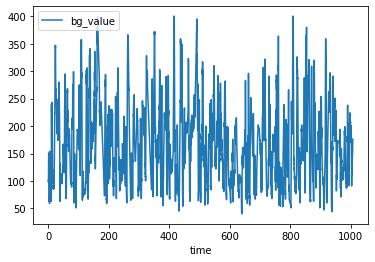

2021-07-13 08:09:06.669 | INFO     | src.helpers.experiment:create_tsfresh_dataframe:22 - Found existing picle file. Continuing...
2021-07-13 08:09:06.670 | INFO     | src.helpers.dataframe:read_df:11 - Attempting to read from pickle file dataframes/559_train_0_6_6.pkl
Index(['bg_value__variance_larger_than_standard_deviation',
       'bg_value__has_duplicate_max', 'bg_value__has_duplicate_min',
       'bg_value__has_duplicate', 'bg_value__sum_values',
       'bg_value__abs_energy', 'bg_value__mean_abs_change',
       'bg_value__mean_change', 'bg_value__mean_second_derivative_central',
       'bg_value__median',
       ...
       'bg_value__permutation_entropy__dimension_6__tau_1',
       'bg_value__permutation_entropy__dimension_7__tau_1',
       'bg_value__query_similarity_count__query_None__threshold_0.0',
       'bg_value__matrix_profile__feature_"min"__threshold_0.98',
       'bg_value__matrix_profile__feature_"max"__threshold_0.98',
       'bg_value__matrix_profile__feature_"mean

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lr,Linear Regression,33.405,9685.4895,66.1459,-0.9258,0.2858,0.2494,0.042


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lasso,Lasso Regression,20.7753,9149.9167,59.7824,-0.8211,0.1962,0.1409,0.213
lr,Linear Regression,33.4050,9685.4895,66.1459,-0.9258,0.2858,0.2494,0.042


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lasso,Lasso Regression,20.7753,9149.9167,59.7824,-0.8211,0.1962,0.1409,0.213
ridge,Ridge Regression,20.8516,11904.9395,65.7416,-1.3691,0.2010,0.1400,0.027
lr,Linear Regression,33.4050,9685.4895,66.1459,-0.9258,0.2858,0.2494,0.042


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
en,Elastic Net,20.5133,5960.1705,53.6159,-0.1901,0.1935,0.1390,0.222
lasso,Lasso Regression,20.7753,9149.9167,59.7824,-0.8211,0.1962,0.1409,0.213
ridge,Ridge Regression,20.8516,11904.9395,65.7416,-1.3691,0.2010,0.1400,0.027
lr,Linear Regression,33.4050,9685.4895,66.1459,-0.9258,0.2858,0.2494,0.042


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
en,Elastic Net,20.5133,5960.1705,53.6159,-0.1901,0.1935,0.1390,0.222
lasso,Lasso Regression,20.7753,9149.9167,59.7824,-0.8211,0.1962,0.1409,0.213
ridge,Ridge Regression,20.8516,11904.9395,65.7416,-1.3691,0.2010,0.1400,0.027
lr,Linear Regression,33.4050,9685.4895,66.1459,-0.9258,0.2858,0.2494,0.042
llar,Lasso Least Angle Regression,57.8328,4952.0861,70.3526,-0.0023,0.4430,0.4324,0.301


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
omp,Orthogonal Matching Pursuit,19.3061,970.3916,30.4207,0.8004,0.1877,0.1314,0.027
en,Elastic Net,20.5133,5960.1705,53.6159,-0.1901,0.1935,0.1390,0.222
lasso,Lasso Regression,20.7753,9149.9167,59.7824,-0.8211,0.1962,0.1409,0.213
ridge,Ridge Regression,20.8516,11904.9395,65.7416,-1.3691,0.2010,0.1400,0.027
lr,Linear Regression,33.4050,9685.4895,66.1459,-0.9258,0.2858,0.2494,0.042
llar,Lasso Least Angle Regression,57.8328,4952.0861,70.3526,-0.0023,0.4430,0.4324,0.301


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
omp,Orthogonal Matching Pursuit,19.3061,970.3916,30.4207,0.8004,0.1877,0.1314,0.027
br,Bayesian Ridge,20.0170,2076.7461,41.0274,0.5783,0.1974,0.1355,0.128
en,Elastic Net,20.5133,5960.1705,53.6159,-0.1901,0.1935,0.1390,0.222
lasso,Lasso Regression,20.7753,9149.9167,59.7824,-0.8211,0.1962,0.1409,0.213
ridge,Ridge Regression,20.8516,11904.9395,65.7416,-1.3691,0.2010,0.1400,0.027
lr,Linear Regression,33.4050,9685.4895,66.1459,-0.9258,0.2858,0.2494,0.042
llar,Lasso Least Angle Regression,57.8328,4952.0861,70.3526,-0.0023,0.4430,0.4324,0.301


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
omp,Orthogonal Matching Pursuit,19.3061,9.703916e+02,30.4207,0.8004,0.1877,0.1314,0.027
br,Bayesian Ridge,20.0170,2.076746e+03,41.0274,0.5783,0.1974,0.1355,0.128
en,Elastic Net,20.5133,5.960171e+03,53.6159,-0.1901,0.1935,0.1390,0.222
lasso,Lasso Regression,20.7753,9.149917e+03,59.7824,-0.8211,0.1962,0.1409,0.213
ridge,Ridge Regression,20.8516,1.190494e+04,65.7416,-1.3691,0.2010,0.1400,0.027
lr,Linear Regression,33.4050,9.685489e+03,66.1459,-0.9258,0.2858,0.2494,0.042
llar,Lasso Least Angle Regression,57.8328,4.952086e+03,70.3526,-0.0023,0.4430,0.4324,0.301
par,Passive Aggressive Regressor,594.0409,1.264261e+08,5037.3061,-23835.8195,0.9787,5.1563,0.056


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
omp,Orthogonal Matching Pursuit,19.3061,9.703916e+02,30.4207,0.8004,0.1877,0.1314,0.027
br,Bayesian Ridge,20.0170,2.076746e+03,41.0274,0.5783,0.1974,0.1355,0.128
en,Elastic Net,20.5133,5.960171e+03,53.6159,-0.1901,0.1935,0.1390,0.222
lasso,Lasso Regression,20.7753,9.149917e+03,59.7824,-0.8211,0.1962,0.1409,0.213
ridge,Ridge Regression,20.8516,1.190494e+04,65.7416,-1.3691,0.2010,0.1400,0.027
lr,Linear Regression,33.4050,9.685489e+03,66.1459,-0.9258,0.2858,0.2494,0.042
llar,Lasso Least Angle Regression,57.8328,4.952086e+03,70.3526,-0.0023,0.4430,0.4324,0.301
huber,Huber Regressor,154.3419,7.022214e+04,222.5739,-13.0358,4.2564,0.9321,0.245
par,Passive Aggressive Regressor,594.0409,1.264261e+08,5037.3061,-23835.8195,0.9787,5.1563,0.056


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
omp,Orthogonal Matching Pursuit,19.3061,9.703916e+02,30.4207,0.8004,0.1877,0.1314,0.027
knn,K Neighbors Regressor,23.0387,1.093305e+03,33.0392,0.7784,0.2143,0.1576,0.251
br,Bayesian Ridge,20.0170,2.076746e+03,41.0274,0.5783,0.1974,0.1355,0.128
en,Elastic Net,20.5133,5.960171e+03,53.6159,-0.1901,0.1935,0.1390,0.222
lasso,Lasso Regression,20.7753,9.149917e+03,59.7824,-0.8211,0.1962,0.1409,0.213
ridge,Ridge Regression,20.8516,1.190494e+04,65.7416,-1.3691,0.2010,0.1400,0.027
lr,Linear Regression,33.4050,9.685489e+03,66.1459,-0.9258,0.2858,0.2494,0.042
llar,Lasso Least Angle Regression,57.8328,4.952086e+03,70.3526,-0.0023,0.4430,0.4324,0.301
huber,Huber Regressor,154.3419,7.022214e+04,222.5739,-13.0358,4.2564,0.9321,0.245
par,Passive Aggressive Regressor,594.0409,1.264261e+08,5037.3061,-23835.8195,0.9787,5.1563,0.056


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
omp,Orthogonal Matching Pursuit,19.3061,9.703916e+02,30.4207,0.8004,0.1877,0.1314,0.027
knn,K Neighbors Regressor,23.0387,1.093305e+03,33.0392,0.7784,0.2143,0.1576,0.251
dt,Decision Tree Regressor,25.4151,1.428566e+03,37.7502,0.7106,0.2339,0.1684,0.392
br,Bayesian Ridge,20.0170,2.076746e+03,41.0274,0.5783,0.1974,0.1355,0.128
en,Elastic Net,20.5133,5.960171e+03,53.6159,-0.1901,0.1935,0.1390,0.222
lasso,Lasso Regression,20.7753,9.149917e+03,59.7824,-0.8211,0.1962,0.1409,0.213
ridge,Ridge Regression,20.8516,1.190494e+04,65.7416,-1.3691,0.2010,0.1400,0.027
lr,Linear Regression,33.4050,9.685489e+03,66.1459,-0.9258,0.2858,0.2494,0.042
llar,Lasso Least Angle Regression,57.8328,4.952086e+03,70.3526,-0.0023,0.4430,0.4324,0.301
huber,Huber Regressor,154.3419,7.022214e+04,222.5739,-13.0358,4.2564,0.9321,0.245


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,18.2718,7.313229e+02,27.0135,0.8516,0.1725,0.1231,0.951
omp,Orthogonal Matching Pursuit,19.3061,9.703916e+02,30.4207,0.8004,0.1877,0.1314,0.027
knn,K Neighbors Regressor,23.0387,1.093305e+03,33.0392,0.7784,0.2143,0.1576,0.251
dt,Decision Tree Regressor,25.4151,1.428566e+03,37.7502,0.7106,0.2339,0.1684,0.392
br,Bayesian Ridge,20.0170,2.076746e+03,41.0274,0.5783,0.1974,0.1355,0.128
en,Elastic Net,20.5133,5.960171e+03,53.6159,-0.1901,0.1935,0.1390,0.222
lasso,Lasso Regression,20.7753,9.149917e+03,59.7824,-0.8211,0.1962,0.1409,0.213
ridge,Ridge Regression,20.8516,1.190494e+04,65.7416,-1.3691,0.2010,0.1400,0.027
lr,Linear Regression,33.4050,9.685489e+03,66.1459,-0.9258,0.2858,0.2494,0.042
llar,Lasso Least Angle Regression,57.8328,4.952086e+03,70.3526,-0.0023,0.4430,0.4324,0.301


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,18.2718,7.313229e+02,27.0135,0.8516,0.1725,0.1231,0.951
omp,Orthogonal Matching Pursuit,19.3061,9.703916e+02,30.4207,0.8004,0.1877,0.1314,0.027
knn,K Neighbors Regressor,23.0387,1.093305e+03,33.0392,0.7784,0.2143,0.1576,0.251
dt,Decision Tree Regressor,25.4151,1.428566e+03,37.7502,0.7106,0.2339,0.1684,0.392
br,Bayesian Ridge,20.0170,2.076746e+03,41.0274,0.5783,0.1974,0.1355,0.128
en,Elastic Net,20.5133,5.960171e+03,53.6159,-0.1901,0.1935,0.1390,0.222
lasso,Lasso Regression,20.7753,9.149917e+03,59.7824,-0.8211,0.1962,0.1409,0.213
ridge,Ridge Regression,20.8516,1.190494e+04,65.7416,-1.3691,0.2010,0.1400,0.027
lr,Linear Regression,33.4050,9.685489e+03,66.1459,-0.9258,0.2858,0.2494,0.042
llar,Lasso Least Angle Regression,57.8328,4.952086e+03,70.3526,-0.0023,0.4430,0.4324,0.301


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,18.2718,7.313229e+02,27.0135,0.8516,0.1725,0.1231,0.951
omp,Orthogonal Matching Pursuit,19.3061,9.703916e+02,30.4207,0.8004,0.1877,0.1314,0.027
knn,K Neighbors Regressor,23.0387,1.093305e+03,33.0392,0.7784,0.2143,0.1576,0.251
dt,Decision Tree Regressor,25.4151,1.428566e+03,37.7502,0.7106,0.2339,0.1684,0.392
br,Bayesian Ridge,20.0170,2.076746e+03,41.0274,0.5783,0.1974,0.1355,0.128
en,Elastic Net,20.5133,5.960171e+03,53.6159,-0.1901,0.1935,0.1390,0.222
lasso,Lasso Regression,20.7753,9.149917e+03,59.7824,-0.8211,0.1962,0.1409,0.213
ridge,Ridge Regression,20.8516,1.190494e+04,65.7416,-1.3691,0.2010,0.1400,0.027
lr,Linear Regression,33.4050,9.685489e+03,66.1459,-0.9258,0.2858,0.2494,0.042
llar,Lasso Least Angle Regression,57.8328,4.952086e+03,70.3526,-0.0023,0.4430,0.4324,0.301


,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,17.3170,697.6223,26.4125,0.8520,0.1729,0.1210
1,18.3967,711.1489,26.6674,0.8628,0.1659,0.1239
2,18.0523,659.0305,25.6716,0.8605,0.1696,0.1232
3,19.4310,823.9027,28.7037,0.8364,0.1765,0.1264
4,17.5536,631.9924,25.1395,0.8760,0.1588,0.1144
5,18.9525,764.6033,27.6515,0.8563,0.1752,0.1257
6,18.8245,783.7103,27.9948,0.8379,0.1826,0.1321
7,18.4343,780.9061,27.9447,0.8397,0.1778,0.1236
8,17.5275,644.6204,25.3894,0.8724,0.1679,0.1209
9,18.2291,815.6925,28.5603,0.8215,0.1777,0.1201


,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,17.3170,697.6223,26.4125,0.8520,0.1729,0.1210
1,18.3967,711.1489,26.6674,0.8628,0.1659,0.1239
2,18.0523,659.0305,25.6716,0.8605,0.1696,0.1232
3,19.4310,823.9027,28.7037,0.8364,0.1765,0.1264
4,17.5536,631.9924,25.1395,0.8760,0.1588,0.1144
5,18.9525,764.6033,27.6515,0.8563,0.1752,0.1257
6,18.8245,783.7103,27.9948,0.8379,0.1826,0.1321
7,18.4343,780.9061,27.9447,0.8397,0.1778,0.1236
8,17.5275,644.6204,25.3894,0.8724,0.1679,0.1209
9,18.2291,815.6925,28.5603,0.8215,0.1777,0.1201


2021-07-13 08:10:18.254 | INFO     | __main__:run:58 - Processing model: LGBMRegressor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,18.3031,718.6608,26.8079,0.858,0.1726,0.1248


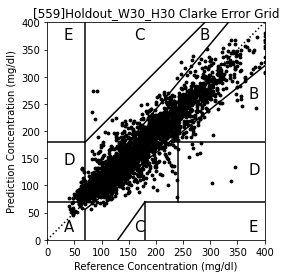

2021-07-13 08:10:19.265 | INFO     | src.helpers.experiment:create_ds_name:12 - dataframes/559_test_0_6_6.pkl
2021-07-13 08:10:19.294 | INFO     | src.helpers.experiment:create_tsfresh_dataframe:19 - {'ohio_no': 559, 'scope': 'test', 'train_ds_size': 0, 'window_size': 6, 'prediction_horizon': 6, 'minimal_features': False}


<Figure size 432x288 with 0 Axes>

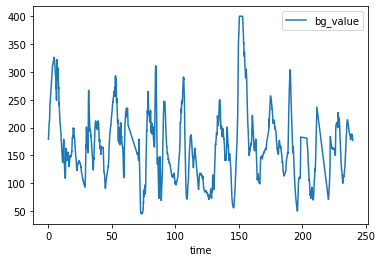

2021-07-13 08:10:19.719 | INFO     | src.helpers.experiment:create_tsfresh_dataframe:22 - Found existing picle file. Continuing...
2021-07-13 08:10:19.722 | INFO     | src.helpers.dataframe:read_df:11 - Attempting to read from pickle file dataframes/559_test_0_6_6.pkl


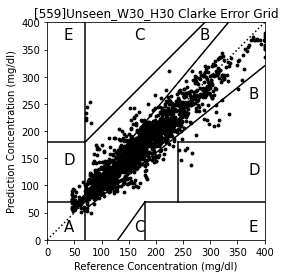

                                                                       0
patient                                                              559
window                                                    12(60 minutes)
horizon                                                    6(30 minutes)
model                  LGBMRegressor(boosting_type='gbdt', class_weig...
model_name                                                 LGBMRegressor
internal_cga_analysis                             [2702, 425, 6, 101, 0]
internal_rmse                                                  24.725948
internal_rmadex                                              1715.710901
unseen_cga_analysis                                [2188, 267, 6, 36, 0]
unseen_rmse                                                    23.548065
unseen_rmadex                                                 231.849107
                                                                       0
patient                                            

<Figure size 432x288 with 0 Axes>

In [7]:
patients = [559]
windows = [12, 6]
horizons = [6]
experiments = [run(patient,window, horizon) for patient in patients for window in windows for horizon in horizons]
for experiment in experiments:
    df = pandas.DataFrame.from_dict(experiment, orient='index')
    print(df)
